In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [2]:
if (torch.cuda.is_available()):
    device=torch.device("cuda")
    print(device,torch.cuda.get_device_name())
else:
    device=torch.device("cpu")
    print(device)

cuda GeForce GTX 1070


(1120, 1500, 3)


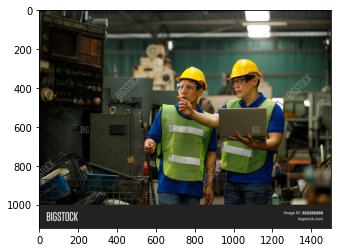

In [3]:
img0= cv2.imread("worker.jpg")
img0 = cv2.cvtColor(img0,cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

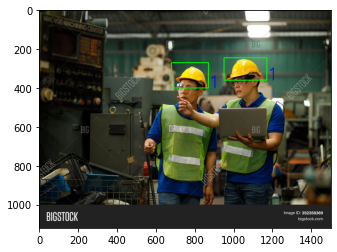

In [4]:
bbox0 = np.array([[270,680,400,870],[245,950,360,1170]])
labels = np.array([1,1])
img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(0, 255, 0), thickness=3) 
    cv2.putText(img0_clone, str(int(labels[i])), (bbox0[i][3], bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) 
plt.imshow(img0_clone)
plt.show()    

In [5]:
img = cv2.resize(img0,dsize=(800,800),interpolation=cv2.INTER_CUBIC)


In [6]:
Wratio= 800/img0.shape[1]
Hratio= 800/img0.shape[0]
ratioLst=[Hratio,Wratio,Hratio,Wratio]
bbox=[]
for box in bbox0:
    box = [int(a*b) for a,b in zip(box,ratioLst)]
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[192 362 285 464]
 [175 506 257 624]]


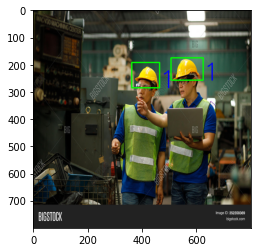

In [7]:
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    cv2.putText(img_clone, str(int(labels[i])), (bbox[i][3], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) # Write the prediction class
plt.imshow(img_clone)
plt.show()    

In [8]:
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))


31


In [9]:
dumy_img = torch.zeros((1,3,800,800)).float()
print(dumy_img.shape)
req_features = []
k = dumy_img.clone().to(device)
for i in fe:
    k = i(k)
    if k.size()[2]<800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features))
print(out_channels)    
    
    

torch.Size([1, 3, 800, 800])
30
512


In [10]:
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [11]:
transform = transforms.Compose([transforms.ToTensor()]) 
imgTensor = transform(img).to(device) 
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


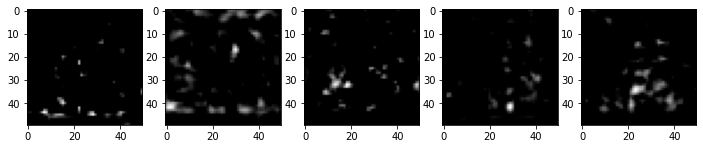

In [12]:
imgArray=out_map.data.cpu().numpy().squeeze(0)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5): 
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(imgArray[i], cmap='gray')
    figNo +=1
plt.show()

In [13]:
fe_size = (800//16)
ctr_x = np.arange(16,(fe_size+1)*16,16)
ctr_y = np.arange(16,(fe_size+1)*16,16)
print(len(ctr_x),ctr_x)


50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [14]:
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index +=1
print(ctr.shape)
    

(2500, 2)


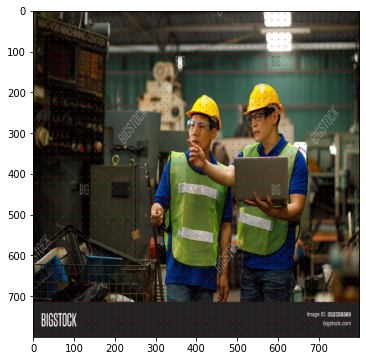

In [15]:
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255, 0, 0), thickness=1) 
plt.imshow(img_clone)
plt.show()

In [16]:
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros( ((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1
print(anchor_boxes.shape)

(22500, 4)


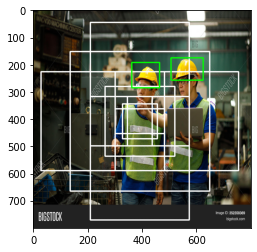

In [17]:
img_clone = np.copy(img)
for i in range(11025, 11034):  
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3)
    
plt.imshow(img_clone)
plt.show()  

In [18]:
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800)
    )[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


In [19]:
#intersection calculation

ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)
    
    

(8940, 2)


In [20]:
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)


[4522 6534]
[0.5789795 0.5905762]
[4522 4529 4796 4803 6534 6780 7004 7008 7010 7016 7236]


In [21]:
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


In [22]:
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [23]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold]= 1
label[max_ious < neg_iou_threshold] = 0


In [24]:
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label==1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index)-int(n_pos)),replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
if len(neg_index)>n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index)-n_neg),replace=False)
    label[disable_index] = -1



 


In [25]:
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)


#  anchor boxes (valid ones)
height = valid_anchor_boxes[:,2] - valid_anchor_boxes [:,0]
width = valid_anchor_boxes[:,3] - valid_anchor_boxes [:,1]
ctr_y = valid_anchor_boxes[:,0] + 0.5 * height
ctr_x = valid_anchor_boxes[:,1]  + 0.5 * width

#  anchor boxes max iou (in valid ones)
base_height = max_iou_bbox[:,2] - max_iou_bbox[:,0]
base_width = max_iou_bbox[:,3] - max_iou_bbox[:,1]
base_ctr_y = max_iou_bbox[:,0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:,1]  + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height,eps)
width = np.maximum(width,eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy,dx,dh,dw)).transpose()
print(anchor_locs.shape)





(8940, 4)
(8940, 4)


In [26]:
anchor_labels = np.empty((len(anchor_boxes),),dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:],dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside,:] = anchor_locs


In [27]:
# Region Proposal Networks

in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels,mid_channels,3,1,1).to(device)
conv1.weight.data.normal_(0,0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor*4,1,1,0).to(device)
reg_layer.weight.data.normal_(0,0.01)
reg_layer.bias.data.zero_()


cls_layer = nn.Conv2d(mid_channels,n_anchor*2,1,1,0).to(device)
cls_layer.weight.data.normal_(0,0.01)
cls_layer.bias.data.zero_()



tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [32]:
x = conv1(out_map.to(device)) 
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [33]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [35]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]


gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)


print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)


torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [36]:
rpn_cls_loss = F.cross_entropy(rpn_score,gt_rpn_score.long().to(device),ignore_index=-1)
print(rpn_cls_loss)

tensor(0.7152, device='cuda:0', grad_fn=<NllLossBackward>)


In [38]:
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)

mask_loc_preds = rpn_loc[mask].view(-1,4)
mask_loc_targets = gt_rpn_loc[mask].view(-1,4)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float()*0.5* x**2) + ((x >= 1).float()*(x-0.5))


torch.Size([22500, 4])
torch.Size([11, 4]) torch.Size([11, 4])
tensor(0.9543, dtype=torch.float64, grad_fn=<SumBackward0>)


In [39]:
rpn_lambda = 10.
N_reg = (gt_rpn_score >0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(1.5828, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


In [40]:
nms_thresh = 0.7  
n_train_pre_nms = 12000 
n_train_post_nms = 2000 
n_test_pre_nms = 6000
n_test_post_nms = 300 
min_size = 16

In [41]:

anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width
print(anc_ctr_x.shape)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4] #每個 anchor box 的 dy
dx = pred_anchor_locs_numpy[:, 1::4] # dx
dh = pred_anchor_locs_numpy[:, 2::4] # dh
dw = pred_anchor_locs_numpy[:, 3::4] # dw
print(dy.shape)


ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500,)
(22500, 1)
(22500, 1)


In [42]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
print(roi.shape)

img_size = (800, 800) #Image size
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi.shape, np.max(roi), np.min(roi))

(22500, 4)
(22500, 4) 800.0 0.0


In [43]:
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0] #min_size=16
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

order = score.ravel().argsort()[::-1]
print(order.shape)

order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape, roi.shape)

(22500,) (22500, 4) (22500,)
(22500,)
(12000,) (12000, 4) (12000, 4)


In [44]:
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [48]:
order = order.argsort()[::-1]
keep = []
while (order.size > 0):
    i = order[0] 
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]]) 
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]
keep = keep[:n_train_post_nms] 
roi = roi[keep] 
print(len(keep), roi.shape)

2000 (2000, 4)


In [49]:
n_sample = 128  # Number of samples from roi 
pos_ratio = 0.25 # Number of positive examples out of the n_samples
pos_iou_thresh = 0.5  # Min iou of region proposal with any groundtruth object to consider it as positive label
neg_iou_thresh_hi = 0.5  # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [50]:
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(2000, 2)


In [51]:
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)

# Assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]
[1 1 1 ... 1 1 1]


In [52]:

pos_roi_per_image = 32 
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if  neg_index.size > 0 :
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)

7
[ 610  789 1284 1399  675  737  792]
121
[1649 1730  606  153  154 1665  971  229 1671 1517  128 1417 1495  817
 1290 1124 1144 1104 1742 1614 1499  480 1047  495 1275 1767 1109 1916
  648 1300  479  932  530 1843 1237 1469 1312  201 1111  456 1811 1211
 1687  372  506 1882  138 1355 1464 1403 1489  783 1616 1134  288  266
 1402  392  670 1692 1046 1650 1904  613  498  384  643 1670 1562  162
  818 1685  680 1584  360  890 1657  481  342  705 1870  937 1581  609
 1055  624  929  786  131  826 1335 1479 1760 1183  925 1715  728 1523
 1135 1547  662 1908 1008 1972  194 1364 1218  645 1449 1749 1609 1672
 1942  466   81 1127  640  387 1795 1580 1699]


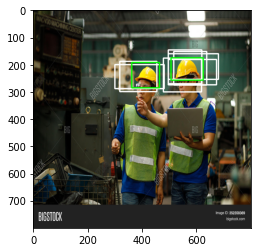

In [53]:
img_clone = np.copy(img)
for i in range(pos_roi_per_this_image):
    y0, x0, y1, x1 = roi[pos_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show() 

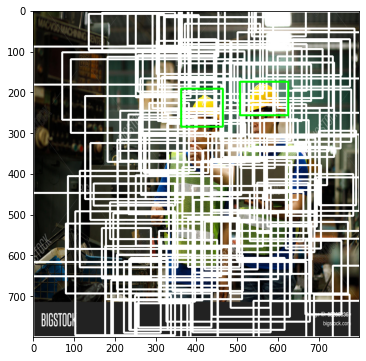

In [54]:
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(neg_roi_per_this_image):
    y0, x0, y1, x1 = roi[neg_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3) 

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()  

In [55]:
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

# Pick the ground truth objects for these sample_roi and 
# later parameterize as we have done while assigning locations to anchor boxes in section 2.
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

(128, 4)
(128, 4)


In [56]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs.shape)

(128, 4)


In [57]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([128, 5])


In [58]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [59]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # Subsampling ratio
rois = rois.long()
num_rois = rois.size(0)
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
output = torch.cat(output, 0)
print(output.size())

torch.Size([128, 512, 7, 7])


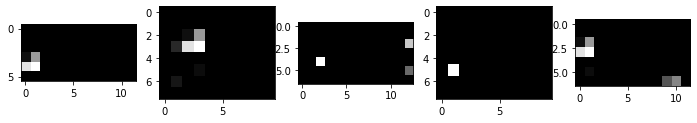

In [60]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    figNo +=1
plt.show()

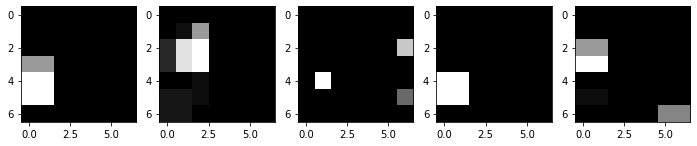

In [61]:
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)[0]
    tmp = tmp[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    figNo +=1
plt.show()

In [62]:
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


In [63]:
roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(device)
cls_loc = nn.Linear(4096, 2 * 4).to(device) 
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(device)

In [64]:
# passing the output of roi-pooling to ROI head 
k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [65]:
# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [67]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [69]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)
print(roi_cls_loss.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([])


In [70]:
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(roi_loc_loss.sum())

torch.Size([128, 2, 4])
torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([7, 4]) torch.Size([7, 4])
tensor(2.3991, dtype=torch.float64, grad_fn=<SumBackward0>)


In [71]:

roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

tensor([[0.9026, 1.0011, 0.7321, 3.0059],
        [0.7188, 2.3498, 1.1298, 0.7945],
        [1.0057, 0.6933, 1.4827, 6.4050],
        [2.8507, 0.7002, 1.1291, 4.1761],
        [0.6886, 0.6977, 0.6914, 3.5254],
        [1.0327, 0.8021, 0.7614, 1.7845],
        [1.2030, 0.7796, 0.6901, 1.5360]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
